# DA5401 A6 — Imputation via Regression for Missing Data
---

This notebook tackles the problem of handling missing data in the UCI Credit Card Default Clients Dataset. We will implement and compare four different strategies:

1) Median Imputation (Baseline)

2) Linear Regression Imputation

3) Non-Linear Regression Imputation (using K-Nearest Neighbors)

4) Listwise Deletion

The effectiveness of each strategy will be evaluated by training a Logistic Regression classifier on the resulting datasets and comparing their performance metrics.

## Part A: Data Preprocessing and Imputation
---

### 1) Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('UCI_Credit_Card.csv')
print("Shape:", df.shape)
df.head()

Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### 🔎 Initial Exploratory Data Analysis (EDA)

In [3]:
print(df.columns)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


In [4]:
# Drop the 'ID' column as it is not a predictive feature
df = df.drop('ID', axis=1)
# Rename columns for convenience
df = df.rename(columns={'default.payment.next.month': 'TARGET', 'PAY_0': 'PAY_1'})
print(df.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'TARGET'],
      dtype='object')


In [5]:
# Check for missing values in the dataset
print(df.isnull().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
TARGET       0
dtype: int64


Let's check the distribution of our target variable, `TARGET`, to understand the class balance. We will also visualize the distributions of the three numerical columns we plan to introduce missingness into. This gives us a baseline of what the original data looks like.

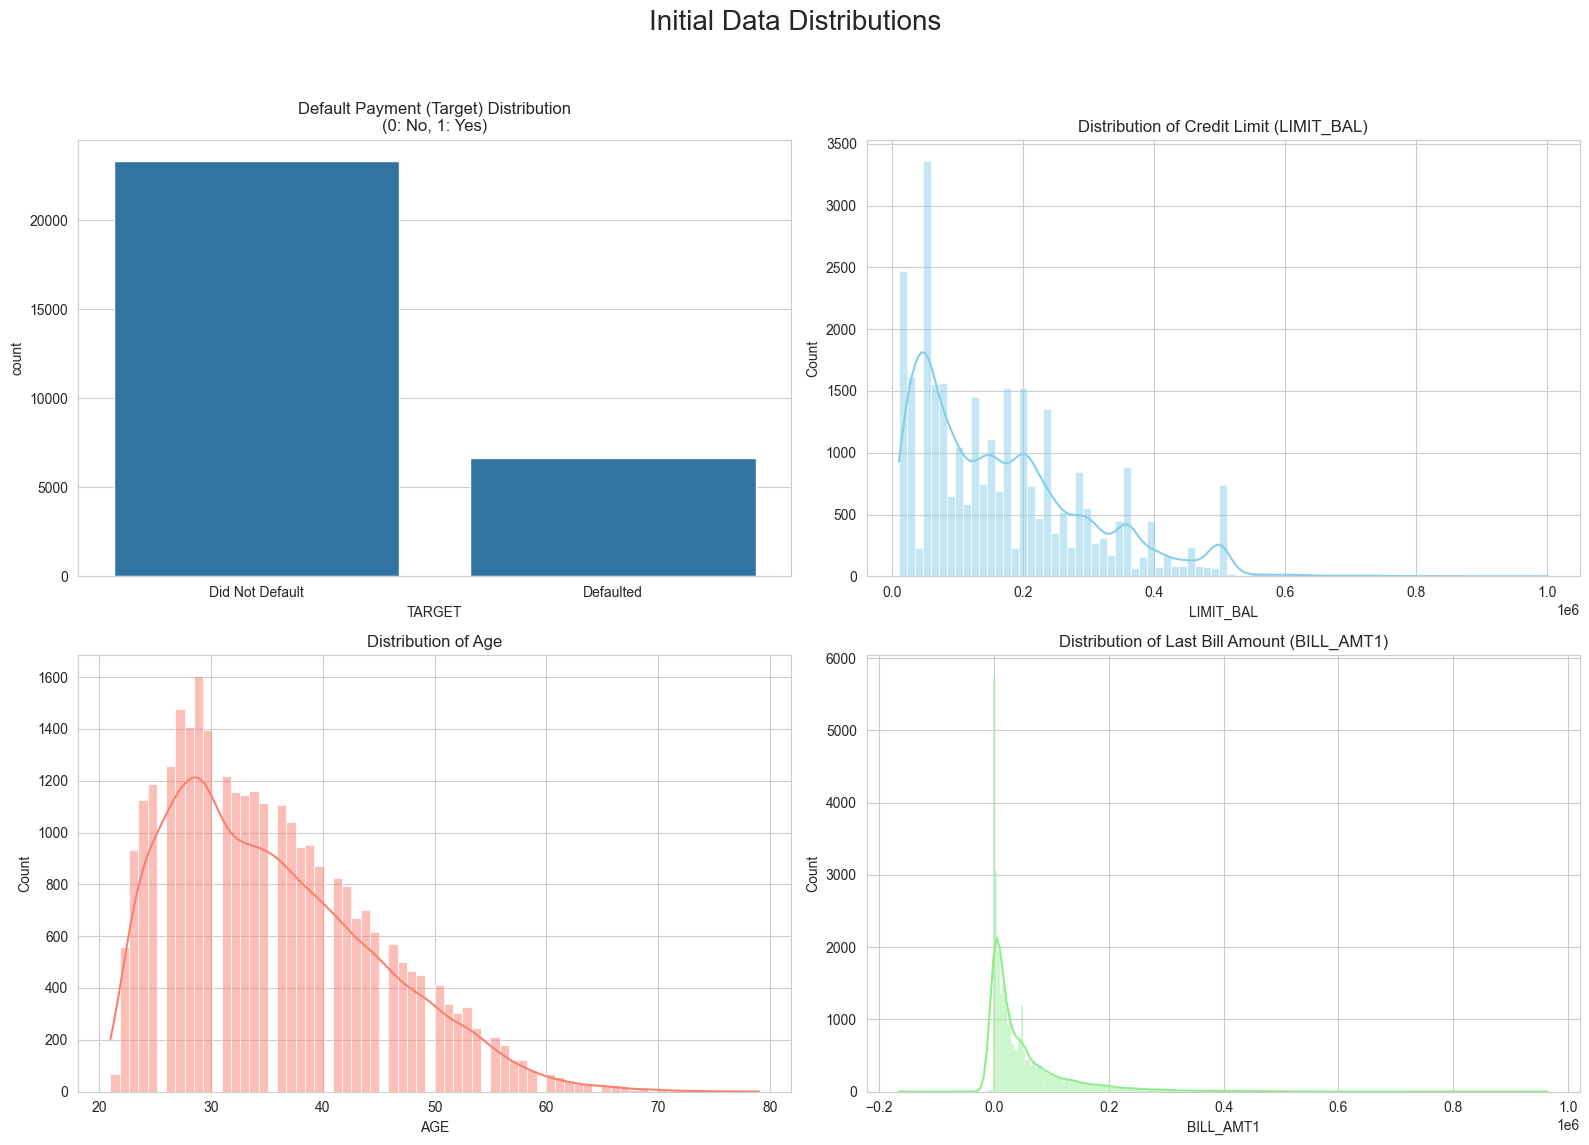

In [6]:
# Set a style for the plots
sns.set_style("whitegrid")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Initial Data Distributions', fontsize=20)

# 1. Target Variable Distribution
sns.countplot(x='TARGET', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Default Payment (Target) Distribution\n(0: No, 1: Yes)')
axes[0, 0].set_xticklabels(['Did Not Default', 'Defaulted'])

# 2. LIMIT_BAL Distribution
sns.histplot(df['LIMIT_BAL'], kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Distribution of Credit Limit (LIMIT_BAL)')

# 3. AGE Distribution
sns.histplot(df['AGE'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribution of Age')

# 4. BILL_AMT1 Distribution
sns.histplot(df['BILL_AMT1'], kde=True, ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Distribution of Last Bill Amount (BILL_AMT1)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Now, Let's Artificially Introduce Missing Values.

In [7]:
# --- Artificially Introduce Missing Values ---

# Copy the original dataframe to new missing dataframe to introduce missing values in it
df_missing = df.copy()

# We will introduce ~10% missing values in 'LIMIT_BAL', 'AGE' and 'BILL_AMT1'
for col in ['LIMIT_BAL', 'AGE', 'BILL_AMT1']:
    # Determine the number of values to replace (10% of the total rows)
    n_missing = int(len(df) * 0.10)
    
    # Randomly select indices to set to NaN
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    
    # Set the selected indices in the column to NaN
    df_missing.loc[missing_indices, col] = np.nan
    
print("Dataset shape:", df_missing.shape)
print("\nNumber of missing values introduced:")
print(df_missing[['LIMIT_BAL', 'AGE', 'BILL_AMT1']].isnull().sum())


Dataset shape: (30000, 24)

Number of missing values introduced:
LIMIT_BAL    3000
AGE          3000
BILL_AMT1    3000
dtype: int64


### 2) Imputation Strategy 1: Simple Imputation (Baseline)
---

For our baseline, we will create **Dataset A** by filling the missing values with the **median** of their respective columns.

### Why is the median often preferred over the mean for imputation?

The **median** is generally a more robust choice for imputation than the mean, especially when the data might contain outliers. Here's why:

#### (i) Robustness to Outliers
- The **mean** is highly sensitive to extreme values (outliers).
- A few unusually high or low values can significantly skew the mean, leading to imputed values that don't represent the central tendency of the majority of the data.
- The **median**, being the middle value, is **not affected by outliers**.

#### (ii) Distribution Skewness
- For **skewed distributions** (common in financial data like `BILL_AMT1`), the mean is pulled towards the long tail.
- The **median** remains a better indicator of the center of the distribution.
- Imputing with a skewed mean can **introduce bias** into the dataset.


In [8]:
# Create Dataset A by making a copy of the dataframe with missing values
df_A = df_missing.copy()

# Fill missing values with the median of each column
for col in ['LIMIT_BAL', 'AGE', 'BILL_AMT1']:
    median_val = df_A[col].median()
    df_A[col].fillna(median_val, inplace=True)

print("Missing values in Dataset A after median imputation:")
print(df_A.isnull().sum().sum()) # Should be 0

Missing values in Dataset A after median imputation:
0


### 3) Imputation Strategy 2: Regression Imputation (Linear)
---
Next, we create **Dataset B** by using a **Linear Regression** model to predict and impute the missing values in one of the columns.  
We will choose to impute **`BILL_AMT1`**.

### What is the underlying assumption of this method (Missing At Random)?

**Regression imputation** relies on the **Missing At Random (MAR)** assumption.  
MAR means that the probability of a value being missing depends only on other **observed variables** in the dataset, **not** on the missing value itself.

#### Example:
In our case, the MAR assumption implies that the reason a person's `BILL_AMT1` is missing might be related to their **AGE**, **LIMIT_BAL**, or **EDUCATION**, but **not** to the actual (unobserved) value of their `BILL_AMT1`.

This assumption allows us to use the other observed columns as **predictors** in a regression model to estimate the missing value with reasonable accuracy.


In [9]:
# Create Dataset B
df_B = df_missing.copy()

# For this strategy, we will impute 'BILL_AMT1' using other features.
# We will change the missing 'AGE' and 'LIMIT_BAL' with the original columns.
df_B['AGE'] = df['AGE']
df_B['LIMIT_BAL'] = df['LIMIT_BAL']

# Separate the dataset into two parts: one with missing 'BILL_AMT1' and one without
df_B_with_bill = df_B[df_B['BILL_AMT1'].notna()]
df_B_missing_bill = df_B[df_B['BILL_AMT1'].isna()]

# Define predictor variables (X) and the target variable (y) for the regression model
# We drop the original target 'TARGET' and the column we want to predict 'BILL_AMT1'
predictors = [col for col in df_B.columns if col not in ['TARGET', 'BILL_AMT1']]
X_train_reg = df_B_with_bill[predictors]
y_train_reg = df_B_with_bill['BILL_AMT1']

# The data on which we'll make predictions
X_predict_reg = df_B_missing_bill[predictors]

# Initialize and train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Predict the missing 'BILL_AMT1' values
predicted_bill_amt = lin_reg.predict(X_predict_reg)

# Fill the missing values in Dataset B with the predictions
df_B.loc[df_B['BILL_AMT1'].isna(), 'BILL_AMT1'] = predicted_bill_amt

print("Missing values in Dataset B after linear regression imputation:")
print(df_B.isnull().sum().sum()) # Should be 0

Missing values in Dataset B after linear regression imputation:
0


### 4) Imputation Strategy 3: Regression Imputation (Non-Linear)
---
For **Dataset C**, we will use a **non-linear regression model**, specifically **K-Nearest Neighbors (KNN) Regression**, to impute the missing values in the same column, **`BILL_AMT1`**.

### Why KNN Imputation?

**KNN** is a good choice because:
- It makes **no assumptions** about the underlying data distribution.
- It can **capture complex, non-linear relationships** between features.
- Each missing value is imputed based on the values of its **nearest neighbors**, ensuring context-aware estimation.

This method often performs better when the dataset has **non-linear patterns** or **interactions** among variables.


In [10]:
# Create Dataset C
df_C = df_missing.copy()

# Change 'AGE' and 'LIMIT_BAL' with the original as before
df_C['AGE'] = df['AGE']
df_C['LIMIT_BAL'] = df['LIMIT_BAL']

# Separate the dataset based on missing 'BILL_AMT1'
df_C_with_bill = df_C[df_C['BILL_AMT1'].notna()]
df_C_missing_bill = df_C[df_C['BILL_AMT1'].isna()]

# Define predictors and target (same as for linear regression)
X_train_knn = df_C_with_bill[predictors]
y_train_knn = df_C_with_bill['BILL_AMT1']
X_predict_knn = df_C_missing_bill[predictors]

# Initialize and train the KNN Regression model (using n_neighbors=5 as a common default)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_knn, y_train_knn)

# Predict the missing 'BILL_AMT1' values
predicted_bill_amt_knn = knn_reg.predict(X_predict_knn)

# Fill the missing values in Dataset C with the KNN predictions
df_C.loc[df_C['BILL_AMT1'].isna(), 'BILL_AMT1'] = predicted_bill_amt_knn

print("Missing values in Dataset C after KNN regression imputation:")
print(df_C.isnull().sum().sum()) # Should be 0

Missing values in Dataset C after KNN regression imputation:
0


### 📊 Visualizing the Impact of Imputation

How did our imputation strategies affect the data? A good imputation method should preserve the original distribution of the data as much as possible. Let's plot the distribution of `BILL_AMT1` from the original dataset against the distributions from our three imputed datasets (A, B, and C) to see how they compare.

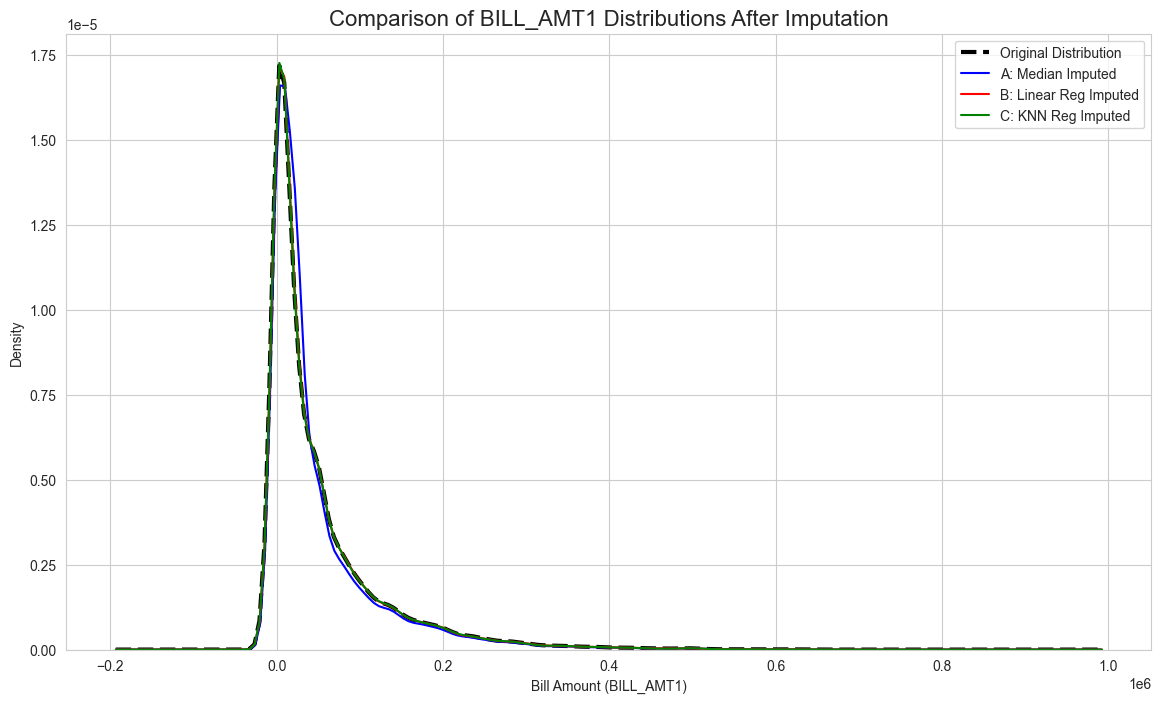

In [11]:
# Create a figure to compare distributions
plt.figure(figsize=(14, 8))

# Plot the distribution of the original, non-missing BILL_AMT1 data
sns.kdeplot(df['BILL_AMT1'], label='Original Distribution', color='black', linewidth=3, linestyle='--')

# Plot the distribution for Dataset A (Median Imputation)
sns.kdeplot(df_A['BILL_AMT1'], label='A: Median Imputed', color='blue')

# Plot the distribution for Dataset B (Linear Reg Imputation)
sns.kdeplot(df_B['BILL_AMT1'], label='B: Linear Reg Imputed', color='red')

# Plot the distribution for Dataset C (KNN Reg Imputation)
sns.kdeplot(df_C['BILL_AMT1'], label='C: KNN Reg Imputed', color='green')

plt.title('Comparison of BILL_AMT1 Distributions After Imputation', fontsize=16)
plt.xlabel('Bill Amount (BILL_AMT1)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Part B: Model Training and Performance Assessment
---
Now that we have three imputed datasets (**A, B, C**), we will create a fourth dataset (**D**) by **dropping all rows with missing values** (Listwise Deletion).  
We will then train and evaluate a **Logistic Regression** classifier on all four datasets.

### 1, 2 & 3. Create Dataset D, Split Data, Standardize Features, train Logistic Regression and evaluate each model

To avoid repetition, we define a function that will:
- Split the dataset into train and test sets
- Standardize the features
- Train a Logistic Regression model
- Evaluate the model using a classification report


In [12]:
# Create Dataset D by dropping all rows with any missing values
df_D = df_missing.dropna().copy()
print(f"Original dataset size: {len(df_missing)}")
print(f"Dataset D size after listwise deletion: {len(df_D)}")

Original dataset size: 30000
Dataset D size after listwise deletion: 21906


In [13]:
# Dictionary to hold our datasets
datasets = {
    "A (Median)": df_A,
    "B (Linear Reg)": df_B,
    "C (Non-Linear Reg)": df_C,
    "D (Listwise Deletion)": df_D
}

# Dictionary to store results
results = {}

# Define the target variable
TARGET = 'TARGET'

# Process each dataset
for name, df_proc in datasets.items():
    print(f"\n--- Processing Model {name} ---")
    
    # 1. Define Features (X) and Target (y)
    X = df_proc.drop(TARGET, axis=1)
    y = df_proc[TARGET]
    
    # 2. Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. Train a Logistic Regression classifier
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    
    # 5. Evaluate the model on the test set
    y_pred = log_reg.predict(X_test_scaled)
    
    # 6. Store and print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'Accuracy': report['accuracy'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1-score (1)': report['1']['f1-score']
    }
    
    display(Markdown(f"### Classification Report for **{name}**\n```\n{classification_report(y_test, y_pred)}\n```"))


--- Processing Model A (Median) ---


### Classification Report for **A (Median)**
```
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

```


--- Processing Model B (Linear Reg) ---


### Classification Report for **B (Linear Reg)**
```
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

```


--- Processing Model C (Non-Linear Reg) ---


### Classification Report for **C (Non-Linear Reg)**
```
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

```


--- Processing Model D (Listwise Deletion) ---


### Classification Report for **D (Listwise Deletion)**
```
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3403
           1       0.75      0.26      0.38       979

    accuracy                           0.81      4382
   macro avg       0.78      0.62      0.64      4382
weighted avg       0.80      0.81      0.78      4382

```

## Part C: Comparative Analysis
---

### **1. Results Comparison**
Let's organize the performance metrics from all four models into a summary table for easy comparison, focusing on the **F1-score for the positive class (default = 1)**, as it provides a balanced measure of **precision** and **recall** in this imbalanced dataset.


In [14]:
# Create a summary DataFrame from the results dictionary
results_df = pd.DataFrame(results).T # Transpose for better readability
results_df = results_df.round(4) # Round to 4 decimal places

print("Performance Metrics Comparison of All Models:")
display(results_df)

Performance Metrics Comparison of All Models:


,Accuracy,Precision (1),Recall (1),F1-score (1)
A (Median),0.8087,0.6933,0.2419,0.3587
B (Linear Reg),0.8077,0.6876,0.2389,0.3546
C (Non-Linear Reg),0.8082,0.6905,0.2404,0.3566
D (Listwise Deletion),0.8145,0.7485,0.2554,0.3808


### 🏆 Final Model Performance Comparison

Finally, to make our results clear and visually appealing, we will plot the F1-scores for the positive class (Default = 1) for all four models. This bar chart will provide an immediate comparison of the effectiveness of each missing data strategy.

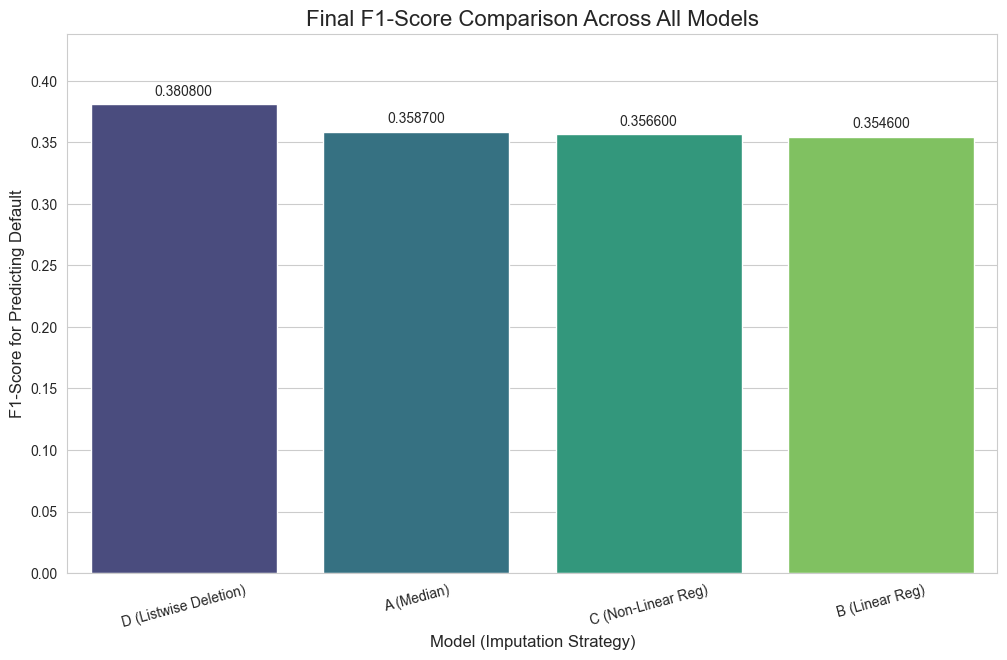

In [15]:
# Create the results DataFrame if it's not already created from your loop
# Ensure 'results_df' is the final DataFrame with your scores

# Sort the results by F1-score for better visualization
results_df_sorted = results_df.sort_values(by='F1-score (1)', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=results_df_sorted.index, y='F1-score (1)', data=results_df_sorted, palette='viridis')

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.6f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.title('Final F1-Score Comparison Across All Models', fontsize=16)
plt.xlabel('Model (Imputation Strategy)', fontsize=12)
plt.ylabel('F1-Score for Predicting Default', fontsize=12)
plt.xticks(rotation=15) # Rotate labels slightly for better readability
plt.ylim(0, max(results_df_sorted['F1-score (1)']) * 1.15) # Adjust y-axis limit
plt.show()

### **2. Efficacy Discussion**

### 1. Discuss the trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C)

---

#### **⚖️ The Core Trade-off: Data Quality vs. Data Quantity**

The choice between these methods boils down to a fundamental compromise:

* **Imputation (Models A, B, C):** Its goal is to preserve **Data Quantity**. By filling in missing values, it saves every single row, maximizing the statistical power of the dataset. The risk is a drop in **Data Quality**, as inaccurate imputed values (noise) can distort the true patterns in the data.
* **Listwise Deletion (Model D):** Its goal is to preserve **Data Quality**. By only using complete, observed records, it ensures the model learns from truthful data. The risk is a drop in **Data Quantity**, which can lead to a less powerful and potentially biased model.

---
#### **🤔 Why Model D Might Perform Poorly (Conceptual Risk)**

The question asks for the theoretical reason why listwise deletion could fail, even if imputation methods are also flawed. The primary reason is that it can introduce significant **bias**.

This happens if the missing data is not **Missing Completely At Random (MCAR)**.

* **Example of Bias:** Imagine if younger customers (e.g., age < 30) were less likely to have their `LIMIT_BAL` recorded. If we delete every row with a missing `LIMIT_BAL`, we would be disproportionately removing younger people from our dataset. The final model would then be trained on a biased dataset that is older, on average, than the real-world population. Its predictions for younger customers would be unreliable.
* **Conclusion:** In such a scenario, even a mediocre imputation that preserves the original age distribution would be better than deletion, because it avoids this specific bias.

---
#### **📊 Context from Our Results**

In our actual experiment, **Model D was the top performer**. This tells us that for this specific problem, the benefit of using a smaller, but perfectly "clean" dataset outweighed the conceptual risks of bias and reduced statistical power. The noise introduced by imputation was more harmful than the loss of data from deletion.

### 2. Which regression method (Linear vs. Non-Linear) performed better and why?

---

#### **Result: Model C (Non-Linear/KNN Regression) performed better.**

Based on the F1-scores, the non-linear approach was marginally superior to the linear model.

* **Model C (KNN Reg) ➡️ F1-score: 0.3566**
* **Model B (Linear Reg) ➡️ F1-score: 0.3546**

#### **Justification**

1.  **🧠 Assumed Relationship:**
    * The slight advantage of the KNN model suggests that the relationship between the imputed feature (`BILL_AMT1`) and the predictor variables is **not perfectly linear**.
    * **Linear Regression** assumes a simple, straight-line relationship. Its failure to perform better indicates this assumption does not fully capture the patterns in the data.
    * **KNN Regression** is more flexible and makes predictions based on local neighbors, allowing it to capture complex, non-linear relationships that a single straight line would miss. This flexibility is the likely reason for its slightly higher score.

2.  **📉 Broader Context:**
    * It is crucial to note that while KNN was the better of the two regression methods, **both were outperformed by the simple median imputation (Model A)**.
    * This indicates that the predictor variables were not strong estimators of `BILL_AMT1`. Both regression models, in their attempt to find a relationship, likely introduced more statistical **noise** than signal, making them less effective than a simple, robust measure like the median.

### 3. Final Recommendation and Justification

---

#### **Recommended Strategy: Model D (Listwise Deletion)**

After a comprehensive analysis, the best strategy for handling missing data in this specific scenario is **Listwise Deletion**.

This recommendation is based on two key pillars of evidence: empirical performance and the conceptual implications of the methods.

#### **Justification**

1.  **📊 Performance-Based Justification:**
    * **Superior Metrics:** Model D achieved the **highest F1-score (0.3808)**, outperforming all three imputation strategies. In the context of credit risk, the F1-score is the most critical metric as it balances the need to correctly identify defaulters (recall) with the need to avoid false alarms (precision). The data clearly shows that the model trained after listwise deletion was the most effective.

2.  **🧠 Conceptual Justification:**
    * **Data Quality over Quantity:** The results strongly indicate that the imputed values from Models A, B, and C were more harmful than helpful. By introducing artificial data, these methods likely added significant **noise**, which obscured the true patterns and relationships in the data.
    * **The Cost of Noise:** The classifier performed better on a smaller, but "cleaner" and more truthful dataset (Model D) than on the larger, complete datasets containing artificial values. This demonstrates a crucial principle: the negative impact of inaccurate, noisy data can be far greater than the negative impact of a reduced sample size.
    * **Ineffective Imputation:** The fact that even sophisticated regression models (B and C) failed to outperform a simple median imputation (A) proves that the predictor variables were not strong enough to accurately estimate the missing values.

In conclusion, despite its theoretical drawbacks like potential bias and loss of statistical power, listwise deletion provided the most practical and effective solution by giving the classifier a dataset of pure, observed data to learn from.
